In [1]:
from __future__ import print_function
import collections
import numpy as np
import pandas as pd
import random
import math
import pickle
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

import tensorflow as tf

import gensim
import logging

from matplotlib import pylab
%matplotlib inline

# fix random seed for reproducibility
np.random.seed(7)

from pprint import pprint



In [2]:
data_file = "dump_2017_words.txt"


In [3]:
############################################################
# 1. load data
############################################################

# load dataset
print("Loading data...")
data=[]
y=[]

# count words
c = collections.Counter()

count = 0
with open(data_file, "r") as infile:
    for line in infile:
        count += 1
        if count % 50000 == 0:
            print (count)

        l = line.rstrip('\n').split(",")
        # status is first element
        label = l.pop(0)
        # headline is rest
        
        data.append(l)
        y.append(label)
        c.update(l)
        
print("Loaded %d lines." % count)


Loading data...
50000
100000
150000
200000
Loaded 218419 lines.


In [4]:
# dump data as one giant text string

with open("dump_words.txt", "w") as outfile:
    for headline in data:
        for word in headline:
            outfile.write(word)
            outfile.write(" ")


In [5]:
def read_data(filename):
  """Extract the file as a list of words"""
  with open(filename) as f:
    data = tf.compat.as_str(f.read()).split()
  return data

filename = "dump_words.txt"
words = read_data(filename)
print('Data size %d' % len(words))

Data size 2196850


In [8]:
############################################################
# build dataset
############################################################

vocabulary_size = 10000 # pick this to have ~10 occurrences for least popular

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:100])
print("\n")
print('Least common words', count[-10:])
print("\n")
print('Sample data', data[:100])


Most common words (+UNK) [['UNK', 168108], ('domain_otherdomain', 119708), ('subsource_othersubsource', 47862), ('trump', 21141), ('with', 10761), ('domain_youtube.com', 8908), ('us', 8434), ('2017', 7862), ('from', 7768), ('subsource_memeorandum', 7712), ('how', 7301), ('say', 6944), ('new', 6923), ('have', 6614), ('domain_bloomberg.com', 6053), ('domain_nytimes.com', 5645), ('domain_washingtonpost.com', 4919), ('will', 4720), ('about', 4594), ('domain_reuters.com', 4520), ('you', 4509), ('do', 4408), ('after', 4406), ('domain_wsj.com', 4323), ('subsource_SpirosMargaris', 4314), ('that', 4290), ('what', 4273), ('subsource_DRUDGE_REPORT', 4242), ('why', 4216), ('subsource_pdacosta', 4108), ('not', 4033), ('up', 3993), ('over', 3932), ('make', 3918), ('get', 3908), ('your', 3696), ('domain_theguardian.com', 3618), ('domain_ft.com', 3560), ('its', 3538), ('this', 3454), ('subsource_JohnLothian', 3175), ('pdf', 3170), ('subsource_thegarance', 3148), ('year', 3100), ('utc', 3064), ('out', 

In [9]:
############################################################
# function to generate mini batches
############################################################

# generate pairs of words that are collocated as two parallel lists
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])



data: ['domain_otherdomain', 'subsource_newsycombinator', 'UNK', 'hack', 'UNK', 'demonstrate', 'linux', 'steam']

with num_skips = 2 and skip_window = 1:
    batch: ['subsource_newsycombinator', 'subsource_newsycombinator', 'UNK', 'UNK', 'hack', 'hack', 'UNK', 'UNK']
    labels: ['domain_otherdomain', 'UNK', 'hack', 'subsource_newsycombinator', 'UNK', 'UNK', 'demonstrate', 'hack']

with num_skips = 4 and skip_window = 2:
    batch: ['UNK', 'UNK', 'UNK', 'UNK', 'hack', 'hack', 'hack', 'hack']
    labels: ['hack', 'UNK', 'subsource_newsycombinator', 'domain_otherdomain', 'demonstrate', 'subsource_newsycombinator', 'UNK', 'UNK']


In [10]:
# Initialize embeddings to random values or Google News embedddings where available

embedding_size = 300 # Dimension of the embedding vector.
print ("Initializing random embeddings")
initial_vals = np.float32(np.random.uniform(-1,1,size=(vocabulary_size,embedding_size)))

# Look up Google News embeddings and replace where they exist
print ("Loading Google News embedding model")
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# do this once each session, takes a while
try:
    model
except NameError:
    model = gensim.models.Word2Vec.load_word2vec_format('~/mount/ubuntu/pretrained/GoogleNews-vectors-negative300.bin', binary=True)

#copy file above to ramdisk to maybe speedup
#sudo mount -t tmpfs -o size=4096m tmpfs /home/ubuntu/mount/ramdisk

#print(model['computer'])
#print(dictionary['computer'])
#print(reverse_dictionary[2297])
#model.similarity('computer', 'PC')
#print(initial_vals[2297])

print ("Re-initializing to Google News embedding where available")
# for each word in model, use its embeddings as initial val

count = 0
for (v,k) in reverse_dictionary.items():
    if k in model:
        count+=1
        if (count % 1000) == 0:
            print ("Re-initialized %d words" % count)
        initial_vals[v] = model[k]

print ("Re-initialized %d of %d words" % (count,vocabulary_size))
# delete model which takes up a lot of memory (5-6 GB)
del model

2017-07-18 20:16:59,318 : INFO : loading projection weights from ~/mount/ubuntu/pretrained/GoogleNews-vectors-negative300.bin


Initializing random embeddings
Loading Google News embedding model


2017-07-18 20:18:39,318 : INFO : loaded (3000000, 300) matrix from ~/mount/ubuntu/pretrained/GoogleNews-vectors-negative300.bin


Re-initializing to Google News embedding where available
Re-initialized 1000 words
Re-initialized 2000 words
Re-initialized 3000 words
Re-initialized 4000 words
Re-initialized 5000 words
Re-initialized 6000 words
Re-initialized 7000 words
Re-initialized 7296 of 10000 words


In [11]:
############################################################
# word2vec computation graph
############################################################

batch_size = 128
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.
valid_size = 20 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default():
    #, tf.device('/cpu:0'): 
    # unsure why I have to pin to CPU to make it work
    # defeats the purpose of tensorflow if you can't use GPU
    
    # Input data.
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    tf_learning_rate = tf.placeholder(tf.float32)
    
    # Variables.
    embeddings = tf.Variable(initial_vals)
    # (initialize to random or Google News value from previous cell)
    # tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    softmax_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],
                                                      stddev=1.0 / math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
    
    # Model.
    # Look up embeddings for inputs.
    embed = tf.nn.embedding_lookup(embeddings, train_dataset)
    # Compute the softmax loss, using a sample of the negative labels each time.
    loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, train_labels, embed,
                                                     num_sampled, vocabulary_size))
    
    # Optimizer.
    # Note: The optimizer will optimize the softmax_weights AND the embeddings.
    optimizer = tf.train.AdagradOptimizer(tf_learning_rate).minimize(loss)
    
    # Compute the similarity between minibatch examples and all embeddings.
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))
    
    # initialize op
    init_op = tf.global_variables_initializer()
  



In [12]:
############################################################
# run computation graph
############################################################

num_steps = 1200001

# high initial learning rate, reduce gradually
initial_lr = 1.0
final_lr = 0.1
#final_lr = 0.01
lr_reduce_rate=(final_lr / initial_lr) ** (1.0/num_steps)
print("lr_reduce_rate: %.10f" % lr_reduce_rate)

with tf.Session(graph=graph) as session:
    session.run(init_op)
    average_loss = 0
    lr = initial_lr
    
    for step in range(num_steps):
        batch_data, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {train_dataset : batch_data, 
                     train_labels : batch_labels, 
                     tf_learning_rate : lr,}
        _, l = session.run([optimizer, loss], 
                           feed_dict=feed_dict,)
        average_loss += l
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
                # The average loss is an estimate of the loss over the last 2000 batches.
                print('Average loss at step %d: %f' % (step, average_loss))
            average_loss = 0
            
        # note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
        lr *= lr_reduce_rate
        
    final_embeddings = normalized_embeddings.eval()

    

lr_reduce_rate: 0.9999980812
Nearest to job: work, employment, salary, internship, hiring, position, apprenticeship, hire,
Nearest to go: come, get, do, sit, stay, take, put, walk,
Nearest to make: making, made, get, give, create, bring, produce, deliver,
Nearest to who: whose, fellow, young, also, veteran, former, him, personally,
Nearest to after: before, later, last, earlier, when, ago, prior, during,
Nearest to from: after, where, through, outside, away, within, around, before,
Nearest to million: billion, mln, 1bn, 2bn, bln, percent, 7bn, total,
Nearest to donald_trump: rubio, palin, hillary, boehner, lindsey, hillary_clinton, mccarthy, mccain,
Nearest to utc: pmi, mattis, gma, rba, vix, davidson, norway, alexis,
Nearest to may: might, could, should, can, will, would, must, likely,
Nearest to domain_youtube.com: calendar, presenter, freelance, lifestyle, clock, buzzfeed, subsource_Jeffrey_Cane, constellation,
Nearest to first: second, third, fourth, fifth, sixth, last, final, nint

Average loss at step 32000: 3.335136
Average loss at step 34000: 3.289589
Average loss at step 36000: 3.177596
Average loss at step 38000: 3.191615
Average loss at step 40000: 3.199860
Nearest to job: employment, salary, career, internship, workforce, worker, hiring, employer,
Nearest to go: come, stuff, walk, probably, coming, turn, happen, skip,
Nearest to make: making, made, give, earn, remind, save, inspire, convince,
Nearest to who: whose, able, young, also, actually, dont, allegedly, still,
Nearest to after: amid, despite, over, because, during, wake, due, within,
Nearest to from: through, outside, thanks, after, hailing, via, made, based,
Nearest to million: billion, 1bn, mln, 2bn, trillion, bln, 5bn, 7bn,
Nearest to donald_trump: trump, trumps, macron, barack_obama, hillary_clinton, britain, rubio, conway,
Nearest to utc: 2017, pdf, htm, shtml, html, jpg, del, png,
Nearest to may: might, could, wont, will, likely, able, cant, try,
Nearest to domain_youtube.com: domain_otherdoma

Average loss at step 62000: 3.141616
Average loss at step 64000: 3.125544
Average loss at step 66000: 3.148371
Average loss at step 68000: 3.068284
Average loss at step 70000: 3.055412
Nearest to job: employment, internship, factory, workforce, worker, productivity, hiring, career,
Nearest to go: come, roar, run, walk, always, happen, hell, belong,
Nearest to make: making, convince, achieve, earn, transform, steer, build, spare,
Nearest to who: able, allegedly, also, dont, young, actually, whose, prosecute,
Nearest to after: despite, amid, during, because, before, wake, earlier, prompt,
Nearest to from: thanks, via, hailing, through, outside, made, into, after,
Nearest to million: billion, mln, 1bn, 000, 2bn, 5bn, thousand, bln,
Nearest to donald_trump: trump, trumps, macron, barack_obama, marco_rubio, hillary_clinton, conway, obamas,
Nearest to utc: 2017, pdf, shtml, htm, jpg, html, png, mp3,
Nearest to may: might, could, wont, will, likely, would, cant, able,
Nearest to domain_youtub

Average loss at step 92000: 3.031374
Average loss at step 94000: 3.025721
Average loss at step 96000: 3.018120
Average loss at step 98000: 3.035126
Average loss at step 100000: 3.024996
Nearest to job: employment, internship, career, workforce, salary, worker, apprenticeship, payroll,
Nearest to go: roar, come, cry, stuff, trickle, sneak, crawl, turn,
Nearest to make: steer, making, create, convince, spare, give, transform, achieve,
Nearest to who: allegedly, able, also, prosecute, accuse, portman, accidentally, unable,
Nearest to after: amid, despite, prompt, because, during, wake, within, briefly,
Nearest to from: via, onto, thanks, after, into, hailing, during, outside,
Nearest to million: billion, 000, mln, 1bn, 2bn, 5bn, bln, billions,
Nearest to donald_trump: trump, marco_rubio, trumps, conway, barack_obama, kerry, hillary_clinton, christie,
Nearest to utc: 2017, shtml, pdf, htm, jpg, html, png, mp3,
Nearest to may: feb, might, could, hammond, jul, june, apr, april,
Nearest to do

Average loss at step 122000: 2.949776
Average loss at step 124000: 2.946943
Average loss at step 126000: 2.947582
Average loss at step 128000: 2.951504
Average loss at step 130000: 2.945474
Nearest to job: worker, internship, career, workforce, tenure, payroll, apprenticeship, outsource,
Nearest to go: roar, come, crawl, trickle, sneak, run, enter, coming,
Nearest to make: give, rake, steer, convince, earn, making, enjoy, spare,
Nearest to who: allegedly, dont, able, young, innocent, portman, elderly, somehow,
Nearest to after: amid, despite, prompt, follow, castile, over, within, briefly,
Nearest to from: onto, via, after, then, into, sends, thanks, driven,
Nearest to million: billion, 000, mln, 5bn, 1bn, 2bn, bln, billions,
Nearest to donald_trump: trump, marco_rubio, trumps, conway, hillary_clinton, barack_obama, christie, kerry,
Nearest to utc: 2017, shtml, pdf, htm, jpg, html, png, mp3,
Nearest to may: might, feb, apr, jul, could, june, jan, november,
Nearest to domain_youtube.com

Average loss at step 152000: 2.899414
Average loss at step 154000: 2.887680
Average loss at step 156000: 2.900116
Average loss at step 158000: 2.888251
Average loss at step 160000: 2.896964
Nearest to job: worker, internship, payroll, workforce, career, employment, tenure, apprenticeship,
Nearest to go: roar, come, enter, crawl, sneak, turn, really, lean,
Nearest to make: rake, steer, give, convince, pave, making, undercut, earn,
Nearest to who: allegedly, prosecute, young, elderly, unable, able, dont, portman,
Nearest to after: amid, despite, briefly, spark, during, over, prompt, follow,
Nearest to from: onto, via, thanks, then, attempt, about, after, sends,
Nearest to million: billion, mln, 000, 1bn, bln, 2bn, 5bn, billions,
Nearest to donald_trump: trump, trumps, barack_obama, hillary_clinton, marco_rubio, kerry, conway, franken,
Nearest to utc: 2017, shtml, htm, pdf, jpg, html, mp4, png,
Nearest to may: feb, apr, jul, might, june, mar, jan, could,
Nearest to domain_youtube.com: dom

Average loss at step 182000: 2.840337
Average loss at step 184000: 2.854223
Average loss at step 186000: 2.844261
Average loss at step 188000: 2.845083
Average loss at step 190000: 2.834999
Nearest to job: internship, tenure, payroll, worker, career, workforce, profession, apprenticeship,
Nearest to go: roar, come, crawl, trickle, really, stuff, mess, enter,
Nearest to make: rake, enjoy, steer, convince, making, give, pave, earn,
Nearest to who: allegedly, young, dont, convict, portman, able, prosecute, somehow,
Nearest to after: amid, despite, briefly, because, unexpectedly, before, over, abruptly,
Nearest to from: onto, attempt, after, about, via, thanks, into, driven,
Nearest to million: billion, mln, 000, bln, 5bn, 1bn, 2bn, billions,
Nearest to donald_trump: trump, trumps, hillary_clinton, barack_obama, marco_rubio, franken, bush, republican,
Nearest to utc: 2017, shtml, htm, pdf, jpg, mp4, html, png,
Nearest to may: jul, apr, feb, mar, jun, jan, june, might,
Nearest to domain_you

Average loss at step 212000: 2.804200
Average loss at step 214000: 2.809507
Average loss at step 216000: 2.795700
Average loss at step 218000: 2.811826
Average loss at step 220000: 2.798881
Nearest to job: payroll, career, workforce, internship, tenure, worker, apprenticeship, profession,
Nearest to go: roar, crawl, come, really, sneak, sail, turn, enter,
Nearest to make: rake, steer, making, convince, give, pave, remake, swallow,
Nearest to who: allegedly, able, dont, unable, young, convict, prosecute, somehow,
Nearest to after: amid, over, briefly, abruptly, unexpectedly, despite, from, before,
Nearest to from: onto, after, attempt, regard, via, contradict, because, seek,
Nearest to million: billion, 000, mln, 1bn, 5bn, billions, bln, 2bn,
Nearest to donald_trump: trump, trumps, marco_rubio, franken, barack_obama, hillary_clinton, everyone, bush,
Nearest to utc: shtml, 2017, htm, pdf, jpg, mp4, html, mp3,
Nearest to may: jul, apr, mar, feb, jan, jun, might, june,
Nearest to domain_yo

Average loss at step 242000: 2.782159
Average loss at step 244000: 2.768504
Average loss at step 246000: 2.768937
Average loss at step 248000: 2.757875
Average loss at step 250000: 2.778126
Nearest to job: payroll, career, workforce, tenure, employment, profession, apprenticeship, internship,
Nearest to go: roar, come, trickle, crawl, enter, really, borrow, honeymoon,
Nearest to make: give, rake, steer, convince, remake, making, pave, swallow,
Nearest to who: allegedly, dont, young, able, somehow, convict, cant, portman,
Nearest to after: amid, over, despite, briefly, from, abruptly, during, before,
Nearest to from: onto, after, into, hub, attempt, via, regard, sends,
Nearest to million: billion, mln, 000, 1bn, 5bn, bln, 7bn, 2bn,
Nearest to donald_trump: trump, trumps, marco_rubio, hillary_clinton, franken, barack_obama, kerry, republican,
Nearest to utc: 2017, shtml, pdf, htm, jpg, mp4, mp3, png,
Nearest to may: could, might, will, november, likely, wont, able, considers,
Nearest to 

Average loss at step 272000: 2.744638
Average loss at step 274000: 2.755464
Average loss at step 276000: 2.746091
Average loss at step 278000: 2.737553
Average loss at step 280000: 2.735345
Nearest to job: payroll, employment, career, workforce, tenure, apprenticeship, internship, percent,
Nearest to go: roar, really, come, crawl, enter, trickle, borrow, turn,
Nearest to make: give, rake, steer, remake, convince, pave, enjoy, making,
Nearest to who: allegedly, dont, somehow, cant, unable, young, prosecute, able,
Nearest to after: amid, despite, follow, briefly, over, before, abruptly, castile,
Nearest to from: onto, after, via, into, sends, infamous, attempt, bound,
Nearest to million: billion, mln, 000, bln, 5bn, 1bn, 7bn, 2bn,
Nearest to donald_trump: trump, trumps, marco_rubio, hillary_clinton, kerry, franken, shameful, dubious,
Nearest to utc: 2017, shtml, htm, pdf, jpg, mp4, mp3, share_idea_stocktwits,
Nearest to may: could, might, will, november, probably, considers, likely, form

Average loss at step 302000: 2.739846
Average loss at step 304000: 2.718798
Average loss at step 306000: 2.732809
Average loss at step 308000: 2.718662
Average loss at step 310000: 2.712476
Nearest to job: career, payroll, apprenticeship, tenure, employment, workforce, profession, incentive,
Nearest to go: roar, come, crawl, really, enter, borrow, trickle, honeymoon,
Nearest to make: remake, rake, give, steer, pave, convince, reassure, tweak,
Nearest to who: allegedly, dont, unable, somehow, portman, able, cant, prosecute,
Nearest to after: amid, despite, briefly, before, over, from, during, abruptly,
Nearest to from: via, after, onto, sends, with, infamous, bound, into,
Nearest to million: billion, mln, 000, 5bn, bln, 1bn, 2bn, 7bn,
Nearest to donald_trump: trump, trumps, hillary_clinton, marco_rubio, franken, shameful, christie, barack_obama,
Nearest to utc: 2017, shtml, htm, pdf, jpg, mp4, aspx, share_idea_stocktwits,
Nearest to may: could, might, will, november, probably, jul, alre

Average loss at step 332000: 2.714465
Average loss at step 334000: 2.713625
Average loss at step 336000: 2.703242
Average loss at step 338000: 2.701758
Average loss at step 340000: 2.703396
Nearest to job: career, payroll, tenure, apprenticeship, workforce, employment, incentive, internship,
Nearest to go: roar, come, crawl, really, turn, get, borrow, trickle,
Nearest to make: remake, rake, give, steer, convince, making, pave, depict,
Nearest to who: allegedly, unable, able, young, somehow, portman, dont, prosecute,
Nearest to after: amid, despite, briefly, over, during, from, when, castile,
Nearest to from: onto, via, after, with, infamous, sends, regard, contradict,
Nearest to million: billion, mln, 000, bln, 5bn, 7bn, 1bn, 2bn,
Nearest to donald_trump: trump, trumps, hillary_clinton, everyone, barack_obama, franken, rex_tillerson, marco_rubio,
Nearest to utc: 2017, shtml, htm, pdf, jpg, mp4, aspx, share_idea_stocktwits,
Nearest to may: could, might, will, november, wont, arent, prob

Average loss at step 362000: 2.723917
Average loss at step 364000: 2.676127
Average loss at step 366000: 2.693577
Average loss at step 368000: 2.695001
Average loss at step 370000: 2.665959
Nearest to job: career, tenure, payroll, apprenticeship, internship, intern, incentive, employment,
Nearest to go: roar, come, really, crawl, turn, honeymoon, enter, get,
Nearest to make: remake, rake, give, making, steer, convince, depict, swallow,
Nearest to who: allegedly, portman, somehow, prosecute, unable, young, dont, able,
Nearest to after: amid, despite, over, briefly, from, follow, during, when,
Nearest to from: after, onto, via, about, with, has, regard, infamous,
Nearest to million: billion, mln, 000, bln, 5bn, 7bn, 1bn, 2bn,
Nearest to donald_trump: trump, trumps, everyone, hillary_clinton, rex_tillerson, kerry, dubious, marco_rubio,
Nearest to utc: 2017, shtml, pdf, htm, jpg, mp4, share_idea_stocktwits, aspx,
Nearest to may: could, might, will, november, jul, arent, june, apr,
Nearest 

Average loss at step 392000: 2.654781
Average loss at step 394000: 2.695898
Average loss at step 396000: 2.668079
Average loss at step 398000: 2.669176
Average loss at step 400000: 2.670878
Nearest to job: career, incentive, payroll, apprenticeship, workforce, employment, internship, tenure,
Nearest to go: roar, come, really, crawl, sneak, get, turn, honeymoon,
Nearest to make: rake, remake, making, convince, give, depict, pave, steer,
Nearest to who: allegedly, portman, somehow, dont, young, unable, prosecute, able,
Nearest to after: amid, despite, over, briefly, from, follow, during, when,
Nearest to from: after, about, onto, via, into, sends, regard, infamous,
Nearest to million: billion, mln, 000, 5bn, bln, 7bn, 1bn, 2bn,
Nearest to donald_trump: trump, trumps, everyone, hillary_clinton, kerry, marco_rubio, rex_tillerson, dubious,
Nearest to utc: 2017, shtml, pdf, htm, jpg, mp4, share_idea_stocktwits, aspx,
Nearest to may: could, might, november, will, jul, corbyn, arent, apr,
Near

Average loss at step 422000: 2.646894
Average loss at step 424000: 2.632294
Average loss at step 426000: 2.650923
Average loss at step 428000: 2.684859
Average loss at step 430000: 2.641447
Nearest to job: career, payroll, incentive, apprenticeship, employment, workforce, worker, internship,
Nearest to go: roar, come, really, crawl, turn, honeymoon, get, sneak,
Nearest to make: remake, rake, give, convince, steer, making, swallow, pave,
Nearest to who: allegedly, portman, young, somehow, dont, unable, able, prosecute,
Nearest to after: amid, despite, over, briefly, follow, abruptly, from, during,
Nearest to from: onto, via, after, into, about, with, infamous, attempt,
Nearest to million: billion, 000, mln, 5bn, bln, 7bn, 1bn, billions,
Nearest to donald_trump: trump, trumps, everyone, hillary_clinton, shameful, barack_obama, marco_rubio, obamas,
Nearest to utc: 2017, shtml, pdf, htm, jpg, share_idea_stocktwits, mp4, aspx,
Nearest to may: could, might, november, will, corbyn, jul, apr, 

Average loss at step 452000: 2.623280
Average loss at step 454000: 2.626291
Average loss at step 456000: 2.623932
Average loss at step 458000: 2.624294
Average loss at step 460000: 2.665273
Nearest to job: career, payroll, employment, tenure, internship, worker, apprenticeship, incentive,
Nearest to go: roar, come, crawl, really, turn, get, honeymoon, sneak,
Nearest to make: remake, rake, steer, give, convince, evade, become, swallow,
Nearest to who: allegedly, dont, portman, unable, young, somehow, wan, accuse,
Nearest to after: amid, despite, follow, over, during, from, when, briefly,
Nearest to from: onto, after, into, via, sends, about, against, with,
Nearest to million: billion, 000, mln, 5bn, bln, 7bn, 1bn, billions,
Nearest to donald_trump: trump, trumps, hillary_clinton, everyone, shameful, kerry, rex_tillerson, trevor,
Nearest to utc: 2017, shtml, pdf, htm, jpg, share_idea_stocktwits, mp4, aspx,
Nearest to may: might, could, jul, november, will, apr, mar, june,
Nearest to doma

Average loss at step 482000: 2.606725
Average loss at step 484000: 2.626320
Average loss at step 486000: 2.608218
Average loss at step 488000: 2.614199
Average loss at step 490000: 2.598403
Nearest to job: career, workforce, payroll, worker, employment, tenure, internship, incentive,
Nearest to go: roar, come, crawl, really, turn, sneak, honeymoon, brawl,
Nearest to make: rake, give, convince, remake, steer, become, depict, evade,
Nearest to who: allegedly, portman, somehow, young, unable, dont, able, prosecute,
Nearest to after: amid, despite, over, during, from, briefly, follow, when,
Nearest to from: after, onto, via, about, into, attempt, with, against,
Nearest to million: billion, 000, mln, 5bn, bln, 7bn, billions, 1bn,
Nearest to donald_trump: trump, trumps, hillary_clinton, everyone, rex_tillerson, obamas, republican, shameful,
Nearest to utc: 2017, shtml, pdf, htm, jpg, share_idea_stocktwits, mp4, aspx,
Nearest to may: jul, could, might, apr, november, mar, jan, feb,
Nearest to

Average loss at step 512000: 2.611253
Average loss at step 514000: 2.609089
Average loss at step 516000: 2.599101
Average loss at step 518000: 2.590197
Average loss at step 520000: 2.601430
Nearest to job: career, payroll, workforce, tenure, incentive, employment, worker, intern,
Nearest to go: roar, come, crawl, really, turn, sneak, get, honeymoon,
Nearest to make: rake, convince, give, remake, steer, become, pave, evade,
Nearest to who: allegedly, young, dont, portman, somehow, unable, prosecute, desperately,
Nearest to after: amid, despite, over, from, follow, during, briefly, with,
Nearest to from: after, onto, attempt, via, with, into, against, about,
Nearest to million: billion, 000, mln, 5bn, bln, 7bn, billions, thousand,
Nearest to donald_trump: trump, trumps, everyone, obamas, hillary_clinton, shameful, rex_tillerson, republican,
Nearest to utc: 2017, shtml, pdf, htm, jpg, share_idea_stocktwits, mp4, aspx,
Nearest to may: jul, apr, could, might, mar, feb, jan, jun,
Nearest to 

Average loss at step 542000: 2.583151
Average loss at step 544000: 2.590448
Average loss at step 546000: 2.597538
Average loss at step 548000: 2.582347
Average loss at step 550000: 2.593091
Nearest to job: career, payroll, tenure, worker, intern, incentive, workforce, employment,
Nearest to go: come, roar, crawl, really, get, honeymoon, turn, borrow,
Nearest to make: rake, convince, give, remake, steer, become, making, pave,
Nearest to who: allegedly, young, portman, dont, somehow, unable, able, prosecute,
Nearest to after: amid, despite, from, over, briefly, follow, when, before,
Nearest to from: after, onto, via, into, attempt, with, about, infamous,
Nearest to million: billion, 000, mln, 5bn, bln, 7bn, billions, 1bn,
Nearest to donald_trump: trump, trumps, hillary_clinton, obamas, everyone, rex_tillerson, dubious, shameful,
Nearest to utc: 2017, shtml, pdf, htm, jpg, share_idea_stocktwits, mp4, aspx,
Nearest to may: jul, apr, mar, jan, feb, might, could, jun,
Nearest to domain_youtu

Average loss at step 572000: 2.569083
Average loss at step 574000: 2.573419
Average loss at step 576000: 2.565935
Average loss at step 578000: 2.583704
Average loss at step 580000: 2.580707
Nearest to job: career, payroll, employment, workforce, worker, tenure, incentive, intern,
Nearest to go: come, roar, really, crawl, get, turn, margaret, honeymoon,
Nearest to make: rake, give, convince, remake, steer, become, making, swallow,
Nearest to who: allegedly, young, dont, somehow, portman, cant, able, desperately,
Nearest to after: amid, from, despite, over, briefly, follow, before, abruptly,
Nearest to from: after, onto, via, with, into, against, infamous, attempt,
Nearest to million: billion, 000, mln, 5bn, bln, 7bn, 1bn, billions,
Nearest to donald_trump: trump, trumps, everyone, obamas, rex_tillerson, hillary_clinton, dubious, republican,
Nearest to utc: 2017, shtml, pdf, htm, jpg, share_idea_stocktwits, mp4, aspx,
Nearest to may: jul, could, might, apr, november, mar, jan, feb,
Neare

Average loss at step 602000: 2.579871
Average loss at step 604000: 2.564754
Average loss at step 606000: 2.565221
Average loss at step 608000: 2.556990
Average loss at step 610000: 2.571287
Nearest to job: career, payroll, employment, worker, workforce, tenure, renewables, intern,
Nearest to go: roar, really, come, crawl, borrow, turn, honeymoon, sneak,
Nearest to make: give, remake, convince, rake, steer, become, making, transform,
Nearest to who: allegedly, dont, young, cant, somehow, portman, able, unable,
Nearest to after: amid, despite, over, from, before, when, follow, during,
Nearest to from: after, onto, via, with, into, about, against, sends,
Nearest to million: billion, 000, mln, 5bn, bln, 7bn, 1bn, billions,
Nearest to donald_trump: trump, trumps, everyone, hillary_clinton, obamas, republican, rex_tillerson, shameful,
Nearest to utc: 2017, shtml, pdf, htm, jpg, share_idea_stocktwits, mp4, aspx,
Nearest to may: could, might, will, november, jul, apr, arent, already,
Nearest t

Average loss at step 632000: 2.557896
Average loss at step 634000: 2.564868
Average loss at step 636000: 2.556174
Average loss at step 638000: 2.555697
Average loss at step 640000: 2.548846
Nearest to job: career, payroll, worker, employment, workforce, tenure, intern, incentive,
Nearest to go: come, really, roar, crawl, get, honeymoon, borrow, turn,
Nearest to make: remake, give, convince, rake, steer, making, become, depict,
Nearest to who: allegedly, dont, young, somehow, portman, cant, unable, able,
Nearest to after: amid, despite, over, from, follow, briefly, during, before,
Nearest to from: after, via, onto, with, infamous, into, sends, about,
Nearest to million: billion, 000, mln, 5bn, bln, 7bn, thousand, 1bn,
Nearest to donald_trump: trump, trumps, everyone, obamas, rex_tillerson, republican, hillary_clinton, shameful,
Nearest to utc: 2017, shtml, pdf, htm, jpg, share_idea_stocktwits, mp4, aspx,
Nearest to may: could, might, will, november, jul, apr, corbyn, june,
Nearest to do

Average loss at step 662000: 2.569160
Average loss at step 664000: 2.558729
Average loss at step 666000: 2.555354
Average loss at step 668000: 2.554735
Average loss at step 670000: 2.536373
Nearest to job: career, payroll, employment, tenure, workforce, intern, incentive, worker,
Nearest to go: come, really, roar, crawl, get, margaret, fall, honeymoon,
Nearest to make: remake, give, convince, rake, steer, become, depict, making,
Nearest to who: allegedly, young, somehow, portman, dont, unable, able, formally,
Nearest to after: amid, despite, over, from, during, when, briefly, follow,
Nearest to from: after, via, onto, with, into, about, infamous, sends,
Nearest to million: billion, 000, mln, 5bn, bln, 7bn, thousand, billions,
Nearest to donald_trump: trump, trumps, obamas, everyone, hillary_clinton, rex_tillerson, shameful, republican,
Nearest to utc: 2017, shtml, pdf, htm, jpg, share_idea_stocktwits, mp4, aspx,
Nearest to may: could, might, will, november, jul, apr, arent, mar,
Neares

Average loss at step 692000: 2.549663
Average loss at step 694000: 2.566678
Average loss at step 696000: 2.556380
Average loss at step 698000: 2.541609
Average loss at step 700000: 2.545268
Nearest to job: career, payroll, employment, tenure, intern, workforce, incentive, worker,
Nearest to go: come, roar, really, crawl, get, honeymoon, margaret, turn,
Nearest to make: remake, rake, give, convince, become, depict, making, steer,
Nearest to who: allegedly, young, portman, somehow, desperately, dont, unable, cant,
Nearest to after: amid, despite, over, from, when, during, briefly, before,
Nearest to from: after, via, onto, into, with, about, infamous, against,
Nearest to million: billion, 000, mln, bln, 5bn, 7bn, billions, thousand,
Nearest to donald_trump: trump, trumps, everyone, hillary_clinton, obamas, rex_tillerson, republican, shameful,
Nearest to utc: 2017, shtml, pdf, htm, jpg, share_idea_stocktwits, mp4, aspx,
Nearest to may: could, might, november, will, jul, apr, corbyn, mull,

Average loss at step 722000: 2.571974
Average loss at step 724000: 2.544734
Average loss at step 726000: 2.558118
Average loss at step 728000: 2.553431
Average loss at step 730000: 2.540827
Nearest to job: career, payroll, incentive, employment, tenure, worker, intern, workforce,
Nearest to go: roar, really, come, get, crawl, honeymoon, sneak, margaret,
Nearest to make: remake, give, convince, rake, become, depict, steer, making,
Nearest to who: allegedly, young, portman, somehow, dont, unable, desperately, able,
Nearest to after: amid, despite, over, from, follow, when, during, briefly,
Nearest to from: after, via, about, onto, into, with, against, infamous,
Nearest to million: billion, 000, mln, bln, 5bn, 7bn, thousand, 1bn,
Nearest to donald_trump: trump, trumps, everyone, obamas, hillary_clinton, rex_tillerson, dubious, entirely,
Nearest to utc: 2017, shtml, pdf, jpg, htm, share_idea_stocktwits, mp4, aspx,
Nearest to may: could, might, november, will, jul, apr, corbyn, june,
Neares

Average loss at step 752000: 2.514948
Average loss at step 754000: 2.534370
Average loss at step 756000: 2.564555
Average loss at step 758000: 2.540995
Average loss at step 760000: 2.552779
Nearest to job: career, payroll, employment, incentive, workforce, worker, tenure, intern,
Nearest to go: roar, really, come, crawl, get, margaret, honeymoon, sneak,
Nearest to make: remake, give, convince, rake, become, making, depict, steer,
Nearest to who: allegedly, young, somehow, portman, accuse, dont, unable, desperately,
Nearest to after: amid, despite, over, from, during, when, briefly, follow,
Nearest to from: after, into, via, about, onto, with, against, infamous,
Nearest to million: billion, 000, mln, 5bn, bln, 7bn, thousand, billions,
Nearest to donald_trump: trump, trumps, everyone, obamas, hillary_clinton, rex_tillerson, republican, shameful,
Nearest to utc: 2017, shtml, pdf, htm, jpg, share_idea_stocktwits, mp4, aspx,
Nearest to may: could, might, november, will, jul, apr, mar, jan,


Average loss at step 782000: 2.519445
Average loss at step 784000: 2.514756
Average loss at step 786000: 2.515869
Average loss at step 788000: 2.559624
Average loss at step 790000: 2.531409
Nearest to job: career, payroll, worker, incentive, employment, workforce, tenure, intern,
Nearest to go: come, roar, really, get, crawl, sneak, honeymoon, fall,
Nearest to make: give, remake, rake, convince, steer, become, swallow, making,
Nearest to who: allegedly, young, somehow, portman, dont, accuse, wan, prosecute,
Nearest to after: amid, despite, over, from, follow, during, when, briefly,
Nearest to from: after, onto, into, via, about, with, attempt, against,
Nearest to million: billion, 000, mln, 5bn, bln, 7bn, thousand, 1bn,
Nearest to donald_trump: trump, trumps, everyone, obamas, hillary_clinton, rex_tillerson, shameful, republican,
Nearest to utc: 2017, shtml, pdf, jpg, share_idea_stocktwits, htm, mp4, aspx,
Nearest to may: might, could, november, jul, will, apr, jan, corbyn,
Nearest to 

Average loss at step 812000: 2.522078
Average loss at step 814000: 2.503170
Average loss at step 816000: 2.512911
Average loss at step 818000: 2.497842
Average loss at step 820000: 2.538898
Nearest to job: career, payroll, worker, workforce, employment, incentive, tenure, intern,
Nearest to go: come, really, roar, crawl, get, margaret, sneak, borrow,
Nearest to make: give, remake, rake, convince, steer, become, swallow, evade,
Nearest to who: allegedly, young, portman, somehow, dont, wan, accuse, anybody,
Nearest to after: amid, despite, over, from, follow, during, when, before,
Nearest to from: after, onto, into, via, about, with, against, infamous,
Nearest to million: billion, 000, mln, 5bn, bln, 7bn, thousand, billions,
Nearest to donald_trump: trump, trumps, everyone, obamas, hillary_clinton, rex_tillerson, republican, shameful,
Nearest to utc: 2017, shtml, pdf, jpg, share_idea_stocktwits, htm, mp4, aspx,
Nearest to may: could, might, jul, november, apr, jun, will, jan,
Nearest to 

Average loss at step 842000: 2.512506
Average loss at step 844000: 2.508104
Average loss at step 846000: 2.496203
Average loss at step 848000: 2.509677
Average loss at step 850000: 2.494613
Nearest to job: career, payroll, worker, workforce, employment, incentive, tenure, intern,
Nearest to go: come, really, roar, crawl, get, fall, margaret, sneak,
Nearest to make: give, rake, convince, remake, become, steer, prove, depict,
Nearest to who: allegedly, young, portman, somehow, accuse, dont, formally, wan,
Nearest to after: amid, despite, over, from, during, when, follow, briefly,
Nearest to from: after, onto, about, into, via, against, with, attempt,
Nearest to million: billion, 000, mln, bln, 5bn, 7bn, thousand, billions,
Nearest to donald_trump: trump, trumps, everyone, obamas, hillary_clinton, rex_tillerson, republican, shameful,
Nearest to utc: 2017, shtml, pdf, htm, share_idea_stocktwits, jpg, mp4, aspx,
Nearest to may: might, could, jul, november, apr, mar, jun, jan,
Nearest to dom

Average loss at step 872000: 2.505891
Average loss at step 874000: 2.509569
Average loss at step 876000: 2.501751
Average loss at step 878000: 2.498781
Average loss at step 880000: 2.489886
Nearest to job: career, payroll, employment, worker, incentive, workforce, intern, tenure,
Nearest to go: come, really, roar, crawl, get, margaret, fall, html,
Nearest to make: give, convince, rake, remake, become, steer, depict, ramp,
Nearest to who: allegedly, young, somehow, portman, dont, accuse, desperately, wan,
Nearest to after: amid, despite, from, over, during, when, follow, briefly,
Nearest to from: after, onto, via, into, about, with, against, attempt,
Nearest to million: billion, 000, mln, 5bn, bln, 7bn, thousand, billions,
Nearest to donald_trump: trump, trumps, obamas, everyone, hillary_clinton, rex_tillerson, republican, shameful,
Nearest to utc: 2017, shtml, pdf, htm, share_idea_stocktwits, jpg, mp4, aspx,
Nearest to may: jul, might, could, apr, jun, november, mar, jan,
Nearest to do

Average loss at step 902000: 2.493629
Average loss at step 904000: 2.488521
Average loss at step 906000: 2.505968
Average loss at step 908000: 2.499968
Average loss at step 910000: 2.496632
Nearest to job: career, payroll, incentive, intern, workforce, worker, tenure, employment,
Nearest to go: come, really, roar, crawl, get, fall, margaret, honeymoon,
Nearest to make: give, convince, rake, remake, become, steer, depict, ramp,
Nearest to who: allegedly, young, somehow, portman, dont, anybody, formally, cant,
Nearest to after: amid, despite, from, over, when, briefly, follow, during,
Nearest to from: after, onto, via, into, with, about, infamous, against,
Nearest to million: billion, 000, mln, 5bn, bln, 7bn, thousand, billions,
Nearest to donald_trump: trump, trumps, everyone, obamas, hillary_clinton, republican, rex_tillerson, dubious,
Nearest to utc: 2017, shtml, pdf, htm, share_idea_stocktwits, jpg, mp4, aspx,
Nearest to may: might, jul, could, apr, november, jun, mar, jan,
Nearest t

Average loss at step 932000: 2.483395
Average loss at step 934000: 2.492681
Average loss at step 936000: 2.483597
Average loss at step 938000: 2.498727
Average loss at step 940000: 2.496197
Nearest to job: career, payroll, incentive, workforce, tenure, worker, intern, employment,
Nearest to go: come, really, roar, get, crawl, margaret, fall, honeymoon,
Nearest to make: give, convince, remake, rake, become, steer, depict, making,
Nearest to who: allegedly, young, somehow, portman, dont, convict, formally, cant,
Nearest to after: amid, despite, from, over, when, during, follow, briefly,
Nearest to from: after, onto, into, via, with, against, about, infamous,
Nearest to million: billion, 000, mln, 5bn, bln, 7bn, thousand, 1bn,
Nearest to donald_trump: trump, trumps, everyone, obamas, rex_tillerson, hillary_clinton, republican, dubious,
Nearest to utc: 2017, shtml, pdf, htm, share_idea_stocktwits, jpg, mp4, aspx,
Nearest to may: could, might, november, jul, apr, will, mar, jun,
Nearest to 

Average loss at step 962000: 2.501130
Average loss at step 964000: 2.481816
Average loss at step 966000: 2.486767
Average loss at step 968000: 2.478915
Average loss at step 970000: 2.480829
Nearest to job: career, payroll, incentive, workforce, employment, tenure, worker, intern,
Nearest to go: come, really, roar, get, crawl, margaret, fall, honeymoon,
Nearest to make: give, convince, remake, rake, become, steer, depict, swallow,
Nearest to who: allegedly, young, somehow, portman, dont, accuse, desperately, formally,
Nearest to after: amid, despite, from, over, when, during, follow, before,
Nearest to from: after, onto, via, into, with, against, about, infamous,
Nearest to million: billion, 000, mln, 5bn, bln, 7bn, thousand, 1bn,
Nearest to donald_trump: trump, trumps, everyone, obamas, rex_tillerson, republican, hillary_clinton, dubious,
Nearest to utc: 2017, shtml, pdf, htm, share_idea_stocktwits, jpg, mp4, aspx,
Nearest to may: could, might, november, will, jul, apr, mar, mull,
Near

Average loss at step 992000: 2.493213
Average loss at step 994000: 2.489041
Average loss at step 996000: 2.487321
Average loss at step 998000: 2.475691
Average loss at step 1000000: 2.480706
Nearest to job: career, payroll, incentive, employment, tenure, worker, workforce, intern,
Nearest to go: come, really, roar, get, crawl, honeymoon, margaret, fall,
Nearest to make: give, remake, convince, rake, become, steer, depict, transform,
Nearest to who: allegedly, young, somehow, portman, dont, prosecute, accuse, cant,
Nearest to after: amid, despite, over, from, when, during, follow, briefly,
Nearest to from: after, via, onto, into, about, with, against, infamous,
Nearest to million: billion, 000, mln, 5bn, bln, 7bn, thousand, billions,
Nearest to donald_trump: trump, trumps, everyone, obamas, hillary_clinton, republican, rex_tillerson, shameful,
Nearest to utc: 2017, shtml, pdf, htm, share_idea_stocktwits, jpg, mp4, aspx,
Nearest to may: could, might, november, will, jul, apr, mar, jan,
N

Average loss at step 1022000: 2.516011
Average loss at step 1024000: 2.491135
Average loss at step 1026000: 2.477583
Average loss at step 1028000: 2.487172
Average loss at step 1030000: 2.475835
Nearest to job: career, payroll, employment, incentive, worker, workforce, intern, tenure,
Nearest to go: really, come, roar, get, crawl, honeymoon, margaret, fall,
Nearest to make: give, remake, convince, rake, become, steer, depict, transform,
Nearest to who: allegedly, young, portman, somehow, formally, cant, accuse, desperately,
Nearest to after: amid, despite, over, when, from, during, follow, briefly,
Nearest to from: after, via, into, onto, with, about, against, infamous,
Nearest to million: billion, 000, mln, bln, 5bn, 7bn, thousand, billions,
Nearest to donald_trump: trump, trumps, obamas, everyone, hillary_clinton, rex_tillerson, republican, shameful,
Nearest to utc: 2017, shtml, pdf, htm, share_idea_stocktwits, jpg, mp4, aspx,
Nearest to may: could, might, november, will, jul, apr, m

Average loss at step 1052000: 2.489450
Average loss at step 1054000: 2.506505
Average loss at step 1056000: 2.497590
Average loss at step 1058000: 2.480927
Average loss at step 1060000: 2.484596
Nearest to job: career, payroll, incentive, tenure, worker, intern, workforce, employment,
Nearest to go: come, really, roar, get, crawl, honeymoon, margaret, fall,
Nearest to make: give, convince, remake, rake, become, steer, depict, making,
Nearest to who: allegedly, young, portman, somehow, accuse, formally, cant, dont,
Nearest to after: amid, despite, over, when, from, during, follow, briefly,
Nearest to from: after, via, onto, into, about, with, against, infamous,
Nearest to million: billion, 000, mln, bln, 5bn, 7bn, thousand, billions,
Nearest to donald_trump: trump, trumps, obamas, everyone, hillary_clinton, rex_tillerson, republican, shameful,
Nearest to utc: 2017, shtml, pdf, share_idea_stocktwits, htm, jpg, mp4, aspx,
Nearest to may: could, might, november, jul, will, apr, mar, jan,
N

Average loss at step 1082000: 2.482999
Average loss at step 1084000: 2.509826
Average loss at step 1086000: 2.495417
Average loss at step 1088000: 2.503261
Average loss at step 1090000: 2.478793
Nearest to job: career, payroll, worker, incentive, employment, workforce, intern, tenure,
Nearest to go: come, really, roar, get, crawl, honeymoon, margaret, html,
Nearest to make: give, convince, remake, rake, become, steer, depict, ramp,
Nearest to who: allegedly, young, portman, somehow, accuse, formally, dont, cant,
Nearest to after: amid, despite, over, when, from, during, follow, briefly,
Nearest to from: after, into, about, via, onto, with, against, infamous,
Nearest to million: billion, 000, mln, 5bn, bln, 7bn, thousand, 100m,
Nearest to donald_trump: trump, trumps, obamas, everyone, hillary_clinton, rex_tillerson, republican, shameful,
Nearest to utc: 2017, shtml, pdf, share_idea_stocktwits, htm, jpg, mp4, aspx,
Nearest to may: could, might, november, jul, will, apr, jan, mar,
Nearest

Average loss at step 1112000: 2.464891
Average loss at step 1114000: 2.465068
Average loss at step 1116000: 2.510571
Average loss at step 1118000: 2.486018
Average loss at step 1120000: 2.499250
Nearest to job: career, payroll, worker, incentive, employment, workforce, intern, tenure,
Nearest to go: come, really, roar, get, crawl, honeymoon, margaret, fall,
Nearest to make: give, convince, remake, rake, become, steer, depict, ramp,
Nearest to who: allegedly, young, portman, somehow, accuse, formally, dont, desperately,
Nearest to after: despite, amid, over, from, when, during, follow, abruptly,
Nearest to from: after, into, via, onto, about, with, against, infamous,
Nearest to million: billion, 000, mln, bln, 5bn, 7bn, thousand, 100m,
Nearest to donald_trump: trump, trumps, obamas, everyone, hillary_clinton, rex_tillerson, republican, shameful,
Nearest to utc: 2017, shtml, pdf, share_idea_stocktwits, htm, jpg, mp4, aspx,
Nearest to may: could, might, november, jul, will, apr, mar, jan,

Average loss at step 1142000: 2.457589
Average loss at step 1144000: 2.467696
Average loss at step 1146000: 2.454560
Average loss at step 1148000: 2.497363
Average loss at step 1150000: 2.483403
Nearest to job: career, payroll, worker, incentive, intern, workforce, employment, tenure,
Nearest to go: come, really, roar, get, crawl, margaret, honeymoon, html,
Nearest to make: give, convince, remake, rake, become, steer, ramp, depict,
Nearest to who: allegedly, young, portman, somehow, accuse, dont, anybody, formally,
Nearest to after: amid, despite, from, over, when, during, follow, briefly,
Nearest to from: after, onto, into, via, about, with, against, infamous,
Nearest to million: billion, 000, mln, 5bn, bln, 7bn, thousand, billions,
Nearest to donald_trump: trump, trumps, everyone, obamas, rex_tillerson, hillary_clinton, republican, jeff_session,
Nearest to utc: 2017, shtml, pdf, share_idea_stocktwits, htm, jpg, mp4, aspx,
Nearest to may: could, might, november, jul, apr, will, jan, m

Average loss at step 1172000: 2.464597
Average loss at step 1174000: 2.455603
Average loss at step 1176000: 2.468493
Average loss at step 1178000: 2.448910
Average loss at step 1180000: 2.466251
Nearest to job: career, payroll, worker, incentive, workforce, intern, tenure, employment,
Nearest to go: come, really, roar, get, crawl, fall, margaret, html,
Nearest to make: give, convince, remake, rake, become, steer, depict, ramp,
Nearest to who: allegedly, young, portman, somehow, anybody, dont, accuse, formally,
Nearest to after: amid, despite, over, from, when, during, follow, briefly,
Nearest to from: after, onto, into, via, about, with, against, infamous,
Nearest to million: billion, 000, mln, 5bn, bln, 7bn, thousand, billions,
Nearest to donald_trump: trump, trumps, everyone, obamas, hillary_clinton, rex_tillerson, republican, jeff_session,
Nearest to utc: 2017, shtml, pdf, share_idea_stocktwits, htm, jpg, mp4, aspx,
Nearest to may: could, might, jul, november, apr, mar, will, jun,
N

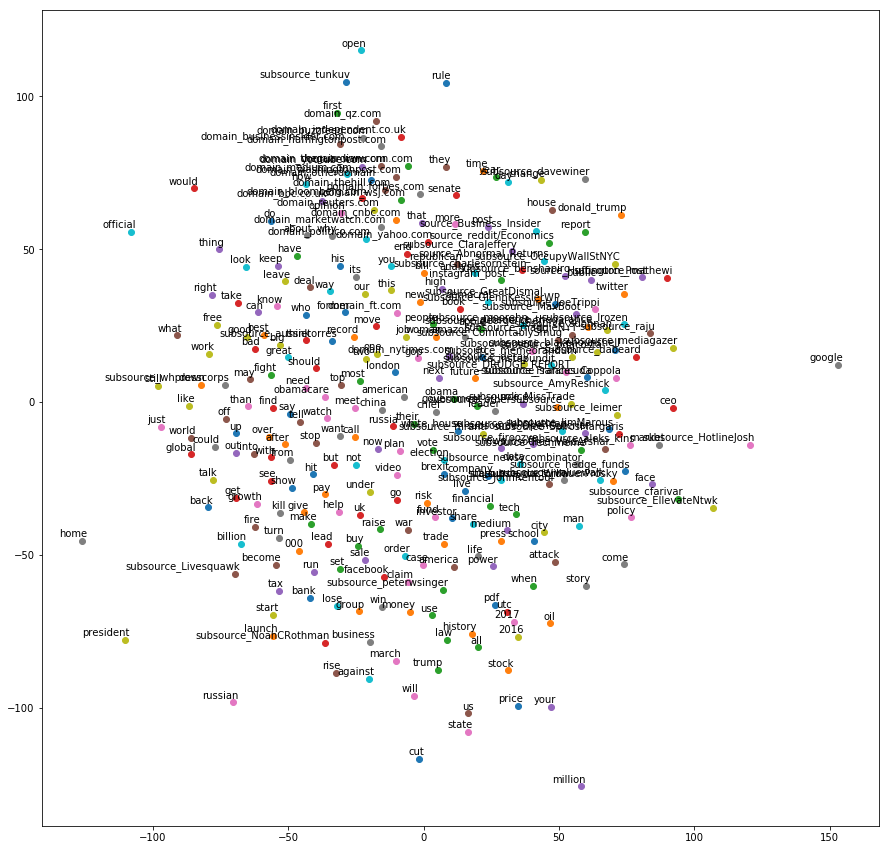

In [13]:
############################################################
# plot in 2D, after transforming 300-vectors with TSNE
############################################################


num_points = 300

tsne = TSNE(perplexity=30,
            n_components=2,
            init='pca',
            n_iter=5000)

two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)


In [12]:
###########################################################
# list collocated words
# allows us to add more mappings for common phrases
############################################################

import operator
import nltk
from nltk.collocations import *
with open(filename, 'r') as myfile:
        data = myfile.read()
# trigrams with at least 100 occurrences       
tokens = nltk.word_tokenize(data)
finder = TrigramCollocationFinder.from_words(tokens)
finder.apply_freq_filter(100)
z = finder.ngram_fd.viewitems()
print(sorted(z, key=operator.itemgetter(1), reverse=True))

# bigrams with at least 200 occurrences       
finder = BigramCollocationFinder.from_words(tokens)
finder.apply_freq_filter(200)
z = finder.ngram_fd.viewitems()
print(sorted(z, key=operator.itemgetter(1), reverse=True))



[(('subsource_othersubsource', 'subsource_othersubsource', 'subsource_othersubsource'), 7074), (('domain_otherdomain', 'subsource_othersubsource', 'source_Huffington_Post'), 6938), (('domain_otherdomain', 'subsource_othersubsource', 'subsource_othersubsource'), 5546), (('domain_otherdomain', 'subsource_othersubsource', 'source_reddit/Economics'), 2120), (('domain_otherdomain', 'subsource_othersubsource', 'source_NYT_Dealbook'), 2063), (('domain_otherdomain', 'subsource_othersubsource', 'source_Business_Insider'), 1905), (('pdf', 'domain_otherdomain', 'subsource_othersubsource'), 1674), (('domain_otherdomain', 'subsource_othersubsource', 'instagram_post'), 1332), (('domain_otherdomain', 'subsource_othersubsource', 'source_Here_Is_The_City'), 1308), (('subsource_EllevateNtwk', 'subsource_EllevateNtwk', 'subsource_EllevateNtwk'), 1307), (('domain_otherdomain', 'subsource_othersubsource', 'source_Abnormal_Returns'), 1258), (('domain_otherdomain', 'subsource_doctorow', 'danismm'), 1203), ((

[(('domain_otherdomain', 'subsource_othersubsource'), 63812), (('subsource_othersubsource', 'subsource_othersubsource'), 17776), (('subsource_othersubsource', 'source_Huffington_Post'), 10537), (('domain_otherdomain', 'subsource_SpirosMargaris'), 7230), (('domain_youtube.com', 'subsource_othersubsource'), 5404), (('pdf', 'domain_otherdomain'), 5370), (('utc', 'domain_otherdomain'), 4977), (('subsource_othersubsource', 'source_reddit/Economics'), 3959), (('subsource_othersubsource', 'source_Business_Insider'), 3943), (('domain_otherdomain', 'subsource_DRUDGE_REPORT'), 3729), (('subsource_othersubsource', 'source_Abnormal_Returns'), 3704), (('domain_otherdomain', 'subsource_doctorow'), 3606), (('domain_otherdomain', 'subsource_aleks_kins'), 3506), (('subsource_othersubsource', 'source_NYT_Dealbook'), 3386), (('subsource_othersubsource', 'source_Here_Is_The_City'), 3370), (('2017', 'domain_otherdomain'), 3327), (('domain_otherdomain', 'subsource_newsycombinator'), 3299), (('domain_otherdo

In [14]:
############################################################
# dump pickle file of embeddings
############################################################

mydict = {}
myreverse = {}

for i in range(vocabulary_size):
    k = reverse_dictionary[i]
    e = final_embeddings[i]
    mydict[k]=i
    myreverse[i]=k

pickle_list = [mydict, myreverse, final_embeddings]

output = open('embeddings.pkl', 'wb')
pickle.dump(pickle_list, output)
output.close()

In [14]:
############################################################
# dump files for embeddings projector
############################################################

# visualize embeddings
# put files somewhere accessible and run via 
# http://projector.tensorflow.org/
    
file1 = 'streeteye_test1.tsv'
file2 = 'streeteye_test2.tsv'

print("creating file %s" % file1)
with open(file1, 'w') as outfile:
    for i in range(vocabulary_size):
        e = final_embeddings[i]
        outfile.write("\t".join(["%f" % val for val in e]))
        outfile.write("\n")

print("creating file %s" % file2)
with open(file2, 'w') as outfile:
    #outfile.write("word\n")
    for i in range(vocabulary_size):
        w = reverse_dictionary[i]
        outfile.write(w)
        outfile.write("\n")


creating file streeteye_test1.tsv
creating file streeteye_test2.tsv
